In [1]:
from models.cifrador_homomorfico_parcial import CifradorHomomorficoParcial
from models.cifrador_homomorfico_completo import CifradorHomomorficoCompleto
from models.cifrador_asimetrico import CifradorAsimetrico
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def wrapped(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        elapsed = end - start
        return result, elapsed

    return wrapper


@wrapped
def encriptar(cifrador, numero):
    return cifrador.encriptar(numero)

In [4]:
def tiempos_cifrado(cifrador, numeros):
    tiempos = []
    numeros_encriptados = []
    for numero in numeros:
        numero_encriptado, elapsed_time = encriptar(cifrador, numero)
        tiempos.append(elapsed_time)
        numeros_encriptados.append(numero_encriptado)
    return tiempos, numeros_encriptados

In [5]:
def barplot_tiempos_cifrado(tiempos, titulo):
    import warnings

    # Suppress FutureWarnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    sns.histplot(tiempos, bins=10)
    plt.xlabel('Tiempo de encriptado [s]')
    plt.ylabel('Frecuencia')
    plt.title(titulo)
    plt.show()

In [2]:
random.seed(42)
random_numbers = [random.randint(1, 10000) for _ in range(500)]

In [6]:
cifrador_homomorfico_parcial = CifradorHomomorficoParcial()
tiempos_del_parcial, numeros_encriptados_parcial = tiempos_cifrado(cifrador_homomorfico_parcial, random_numbers)

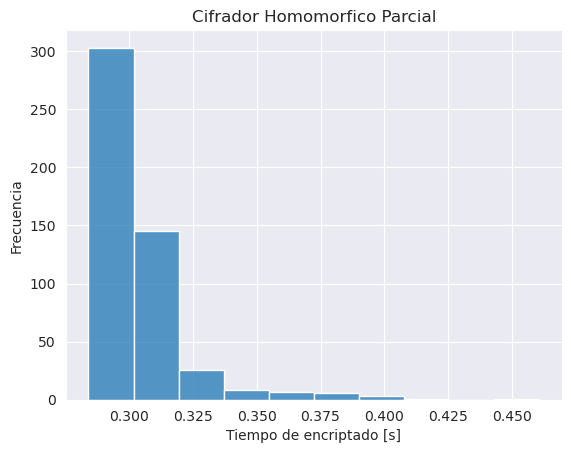

In [7]:
barplot_tiempos_cifrado(tiempos_del_parcial, 'Cifrador Homomorfico Parcial')

In [8]:
cifrador_homomorfico_completo = CifradorHomomorficoCompleto()
tiempos_del_parcial_completo_bfv, numeros_encriptados_completo_bfv = tiempos_cifrado(cifrador_homomorfico_completo,
                                                                                     random_numbers)

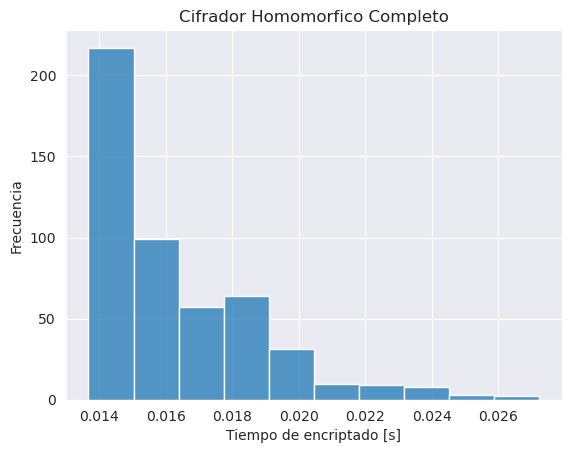

In [9]:
barplot_tiempos_cifrado(tiempos_del_parcial_completo_bfv, 'Cifrador Homomorfico Completo')

In [10]:
cifrador_homomorfico_asimetrico = CifradorAsimetrico()
tiempos_del_parcial_asimetricos, numeros_encriptados_asimetricos = tiempos_cifrado(cifrador_homomorfico_completo,
                                                                                    random_numbers)

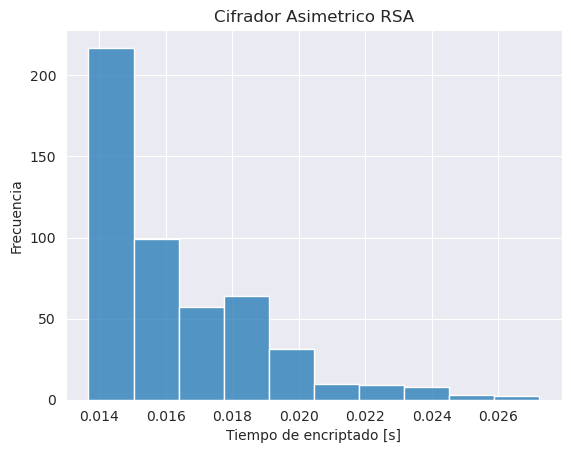

In [11]:
barplot_tiempos_cifrado(tiempos_del_parcial_completo_bfv, 'Cifrador Asimetrico RSA')